# Resaercher Evaluation - H-index

# 説明

## h-index（h指数）とは何か？

h-indexはアメリカの物理学者Jorge E. Hirsch氏が2005年に発表した研究者の評価指標である。

> 要旨：私は、研究者の科学的産出を特徴づける有用な指標として、被引用数がhより大きい論文の数と定義される指数hを提案した。
> 
>> Abstract: I propose the index h, defined as the number of papers with citation number ≥h, as a useful index to characterize the scientific output of a researcher. 
> 
> Hirsch, J. E. (2005). An index to quantify an individual's scientific research output. Proceedings of the National Academy of Sciences, 102(46), 16569-16572. https://www.pnas.org/doi/abs/10.1073/pnas.0507655102

ある科学者が発表したN本論文の中で、**h回以上引用された論文がh本あり**、それ以外のN-h本論文の被引用数が全部hより小さい場合、その科学者の**h-indexはh**である。
 
例えば、h-index=**20**というのは、被引用数が**20**以上の論文が**20**本あり、それ以外の論文はすべて被引用数が20本未満だということである。

## なぜ提案したのか？どうして重要なのか？

リソースが限られた世界で、個人の科学的成果の累積的影響力を定量化することは、評価や比較のために必要とされる。

|指数|長所|短所|
|:-|:-|:-|
|発表論文数(N)|研究者の生産力を測る|論文の影響力が無視される|
|総被引用数(C)|研究者の総影響力を測る|1. 少数の大ヒット論文に歪まれる可能性があり、特に、これらの大ヒットが共著である場合、個人のキャリア全体を代表していない可能性がある。<br>2. 引用度の高いレビューに過度な重みを与えている。|
|平均被引用数(C/N)|異なる年齢の科学者を比較することができる|1. 生産性が高い研究者に不利になる。2. 高被引用数の論文に歪まれる可能性がある。|
|被引用数≥cの論文数|上記の指標の欠点を克服し、広範囲かつ持続的な影響を測る。|cは任意であり、一部の科学者に有利な一方で他の科学者には不利になる。|
|上位q個の論文の被引用数|上記の指標の欠点をほとんど克服する。|1. 単一の数値ではないため、科学者を比較するには困難である。<br>2. qは任意であり、一部の科学者に有利な一方で他の科学者には不利になる。|


# 算出

## １. とある研究者Aのh-indexの計算方法

The h-index of the researcher is: 3


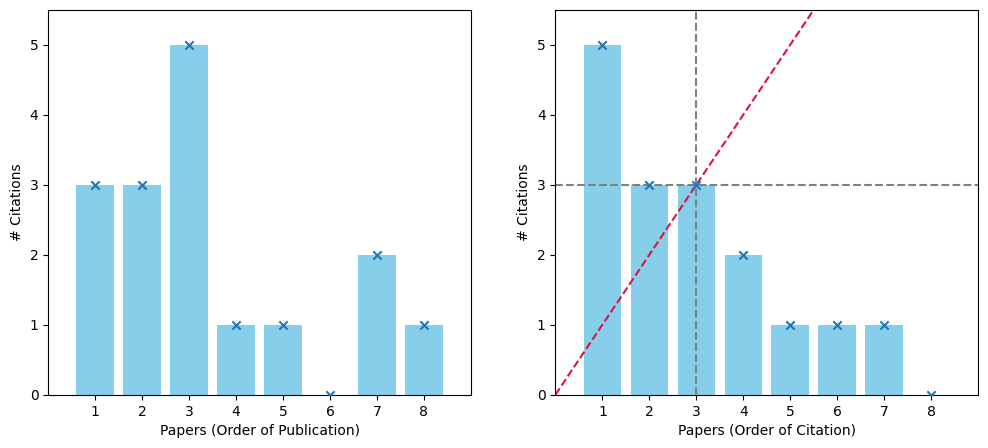

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_c_test(ax, citations, xlabel='Papers', ylabel='# Citations'):
    ax.bar(np.arange(1, len(citations) + 1), citations, color='skyblue')
    ax.scatter(np.arange(1, len(citations) + 1), citations, marker='x', zorder=5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(1, len(citations) + 1, 1))
    ax.set_xlim(0, len(citations) + 1)
    ax.set_ylim(0, max(citations) * 1.1)

# とある研究者の論文の被引用数を入力
c_test = [3,3,5,1,1,0,2,1]

# 被引用数を大きい順に並べ替える
sorted_c_test = sorted(c_test,reverse=True)

# h-indexの算出
# メソッド１：被引用数が論文のランキングより大きい論文を数える。
h_index = np.sum([c >= i + 1 for i, c in enumerate(sorted_c_test)])

# メソッド２：図に示したように、論文被引用数の曲線と45°直線の交点の横座標がh-index。
array = np.arange(1,len(sorted_c_test)+1)
h_index = np.max(np.minimum(sorted_c_test, array))

print("The h-index of the researcher is:", h_index)

# Plot graphs
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_c_test(axs[0], c_test, 'Papers (Order of Publication)', '# Citations')
plot_c_test(axs[1], sorted_c_test, 'Papers (Order of Citation)', '# Citations')
axs[1].plot([0, 10], [0, 10], ls="--", color='crimson')
axs[1].plot([0, axs[1].get_xlim()[1]], [h_index, h_index], color='gray', linestyle='--')
axs[1].plot([h_index, h_index], [0, axs[1].get_ylim()[1]], color='gray', linestyle='--')
plt.show()

## 2. 実データからh-indexの算出

In [ ]:
%pip install pyalex

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
from pyalex import Works, Authors, Sources
import matplotlib.pyplot as plt
import pyalex
import requests

# pyalex.config.email = "your@email.address"
pyalex.config.email = "wangsiyuan1209@gmail.com"

def calculate_h_index(citations):
    citations = np.array(citations)
    citations[::-1].sort()
    array = np.arange(1,citations.size+1)
    h_index = np.max(np.minimum(citations, array))
    return h_index

def plot_citations(ax, citations, xlabel='Papers', ylabel='# Citations', *, h_index=0, loglog=True):
    ax.plot(np.arange(1, len(citations) + 1), citations, marker='o', linestyle='None')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(1, len(citations) + 1, 1))
    if loglog:
        ax.set_yscale('log')  # Set y-axis to log scale
        ax.set_xscale('log')  # Set x-axis to log scale
    lim=min(ax.get_xlim()[1],ax.get_ylim()[1])
    ax.plot([0, lim], [0, lim], ls="--", color='crimson')
    if h_index!=0:
        ax.plot([0, ax.get_xlim()[1]], [h_index, h_index], color='gray', linestyle='--')
        ax.plot([h_index, h_index], [0, ax.get_ylim()[1]], color='gray', linestyle='--')
        plt.show()

def get_all_citations(works_url):
    works_url += '&page={}'
    citations = []
    
    page = 1
    has_more_pages = True
    fewer_than_10k_results = True

    # loop through pages
    while has_more_pages and fewer_than_10k_results:

        # set page value and request page from OpenAlex
        url = works_url.format(page)
        page_with_results = requests.get(url).json()

        # loop through partial list of results
        # extract citation count from every work
        results = page_with_results['results']
        for work in results:
            
            openalex_id = work['id'].replace("https://openalex.org/", "")
            citations.append(work['cited_by_count'])

        # next page
        page += 1

        # end loop when either there are no more results on the requested page 
        # or the next request would exceed 10,000 results
        per_page = page_with_results['meta']['per_page']
        has_more_pages = len(results) == per_page
        fewer_than_10k_results = per_page * page <= 10000
        
    return citations

In [ ]:
# アインシュタインを検索する
pager = Authors().search_filter(display_name="albert einstein")\
            .select(["id","display_name","relevance_score","works_count","cited_by_count"])\
            .paginate(per_page=200)

authors_json = []
for page in pager:
    for item in page:
        authors_json.append(item)
        
authors_pd = pd.DataFrame(authors_json)
# display(authors_pd)

author_id = authors_pd.loc[0,"id"]

data = Authors()[author_id]
# display(pd.Series(data)) # 著者データ。
# print(data["works_api_url"]) # 著者の出版データ

author_works_url=data["works_api_url"]+',is_paratext:false'

In [ ]:
citations = get_all_citations(author_works_url)

--> The specified researcher has an h-index of 78.


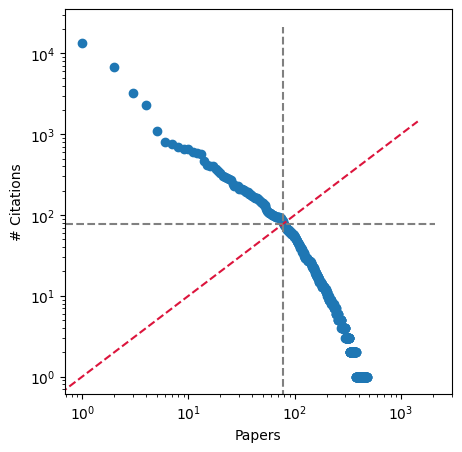

In [ ]:
citations=np.array(citations)
citations[::-1].sort()
# modified binary search
h_index = calculate_h_index(citations)
print(f'--> The specified researcher has an h-index of {h_index}.')

fig, ax = plt.subplots(figsize=(5, 5))
plot_citations(ax, citations, h_index=h_index, loglog=True)
plt.show()

# 探索

## １．重回帰分析によるh-index予測